# Maternity Service Capacity - Model, Simulation & Analysis
## CONTENTS
**Objective 1 - Model current Maternity Service activity using process mapping and queuing network analysis**\
&nbsp; 1.1 &nbsp; Raw Data Manipulation & Variability Analysis\
&nbsp; 1.2 &nbsp; Establish Input Profiles for Mathematical Model

**Objective 2 - Determine current capacity requirements using simulation and mathematical modeling**\
&nbsp; 2.1 &nbsp; Current Capacity Requirements - Historical Data\
&nbsp; 2.2 &nbsp; Current Capacity Simulation Accuracy Analysis\

**Objective 3 - Determine future capacity requirements at 5 and 10 years based on population demographics projections data.**\
&nbsp; 3.1 &nbsp; Capacity Requirements - 5 year forecast\
&nbsp; 3.2 &nbsp; Capacity Requirements - 10 year forecast

## Objective 1 - Model current Maternity Service activity using process mapping and queuing network analysis
### 1.1.  RAW DATA MANIPULATION & VARIABILITY ANALYSIS
**Aim:** Convert the raw data from the extracted hospital data into a form that can be analysed.\
Analysis how different events vary the three critical inputs for the mathematical model;
* Inter-arrival Time, 
* Length of Stay, and 
* Patient Flow Probability 

##### IMPORT PROJECT LIBRARIES

In [1]:
import pandas as pd
import datetime
import time
import os
#import dash  # USE THIS IF RUNNING ON SERVER
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
#import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from jupyter_dash import JupyterDash # USE THIS IF RUNNING ON JUPYTER
import numpy as np
import math

##### CONVERSION OF EVENTS INTO LIKE GROUPINGS
Based on results of variability analysis events that have the same profile for the three mathematical models are grouped together.\
Grouping like factors together improves the accuracy of the model by providing more historical data points

In [2]:
##### CONVERSION FACTORS BASED ON FINDINGS FROM VARIABILITY ANALYSIS
timeconv = {'Admission_Period':['Planned','Unplanned','Unplanned','Unplanned','Unplanned','Planned',
                                'Planned','Planned','Planned','Unplanned','Unplanned','Unplanned',
                                'Unplanned','Unplanned','Unplanned','Unplanned','Unplanned','Planned',
                                'Planned','Planned','Planned','Planned','Planned','Planned'],
            'Hour_of_Day': [0,1,2,3,4,5,
                            6,7,8,9,10,11,
                            12,13,14,15,16,17,
                            18,19,20,21,22,23]}


dayconv = {'Day_Type':['Weekday','Weekday','Weekday','Weekday','Weekday','Weekend','Weekend'],
           'Day': [0,1,2,3,4,5,6]}


event_activity = {'Event_Activity':['High','High','High','Low','Normal','Normal','Low','Low'],
                  'Event':['AFTERXMAS','B4EASTER','BEFOREXMAS','EASTER','NONE','SCHOOL','XMAS','PUBLIC'],
                  'Event_Significance':[3,3,3,1,3,3,1,2]
                 }

In [3]:
timeconv_df = pd.DataFrame.from_dict(timeconv)
timeconv_df

Admission_Period  Hour_of_Day
0           Planned            0
1         Unplanned            1
2         Unplanned            2
3         Unplanned            3
4         Unplanned            4
5           Planned            5
6           Planned            6
7           Planned            7
8           Planned            8
9         Unplanned            9
10        Unplanned           10
11        Unplanned           11
12        Unplanned           12
13        Unplanned           13
14        Unplanned           14
15        Unplanned           15
16        Unplanned           16
17          Planned           17
18          Planned           18
19          Planned           19
20          Planned           20
21          Planned           21
22          Planned           22
23          Planned           23

In [4]:
dayconv_df = pd.DataFrame.from_dict(dayconv)
dayconv_df

Day_Type  Day
0  Weekday    0
1  Weekday    1
2  Weekday    2
3  Weekday    3
4  Weekday    4
5  Weekend    5
6  Weekend    6

In [5]:
event_activity_df = pd.DataFrame.from_dict(event_activity)
event_activity_df

Event_Activity       Event  Event_Significance
0           High   AFTERXMAS                   3
1           High    B4EASTER                   3
2           High  BEFOREXMAS                   3
3            Low      EASTER                   1
4         Normal        NONE                   3
5         Normal      SCHOOL                   3
6            Low        XMAS                   1
7            Low      PUBLIC                   2

##### FUNCTIONS FOR DATA MANIPULATION

In [6]:
def clean_transfers_data():
    ##### CLEAN TRANSFERS DATA
    df = pd.read_csv('transfers.csv')
    df = df.rename(columns = {'Start_Bed_Dttm':'Start', 'End_Bed_Dttm':'End'})
    df = df.drop(columns=['Transfers', 'Bed_Code', 'Full Flow Code', 'Current Flow Code', '1st Level','PASID'])
    date_cols = ['Start', 'End']
    df[date_cols] = df[date_cols].apply(pd.to_datetime, format='%d/%m/%y %H:%M', errors='raise')
    return df

def clean_events_data():
    ###### CLEAN EVENTS AND PUBLIC HOLIDAY DATA
    df = pd.read_csv('exception_dates.csv')
    df = df.rename(columns = {'DATE':'Date', 'EVENT':'Event'})
    df['Date'] = df['Date'].apply(pd.to_datetime, format='%d/%m/%Y', errors='coerce')
    df['Date'] = df['Date'].dt.date
    df = pd.merge(df, event_activity_df, how='left', on='Event')
    df = df.sort_values(['Date', 'Event_Significance'], ascending = True)
    df = df.groupby(['Date']).first().reset_index()
    df = df.drop(columns=['Event_Significance'])
    return df

def drop_records(df):
    ###### DROPS WARD CODES DPS AND ON FROM THE ANALYSIS
    index_names = df.loc[(df.Ward_Code == 'DPS') | (df.Ward_Code == 'ON') | (df.End.isnull())].index
    df = df.drop(index_names)
    return df

def add_next_ward(df):
    ##### ADDS A COLUMN TO THE DATA TABLE THAT SHOWS WHICH WARD THE PATIENT IS GOING NEXT
    df = df.sort_values(['Link', 'Start'])
    df['Next_Ward'] = np.where(df.Link == df.Link.shift(-1), df.Ward_Code.shift(-1),
                              np.where(df.Ward_Code != 'OUT', 'OUT','NONE'))
    return df

def add_out_transfer(df):
    ###### ADDS RECORD IN ROW IN RECORD TO SHOW WHENT THE PATIENT LEAVES THE HOSPITAL
    df  = df.loc[df.Next_Ward == 'OUT',:].copy()
    df['Start'] = df['End']
    df['Ward_Code'] = 'OUT'
    df['Next_Ward'] = 'NONE'
    return df

def add_hierarical_data(df):
    ####### ADD HIERARICAL DATA TO THE DATASET
    #DAY OF THE WEEK
    df = df.dropna(subset=['Start'])
    df = df.copy()
    df['Day'] = df.Start.dt.weekday
    df = pd.merge(df, dayconv_df, how='left', on='Day')
    #MONTH NAME
    df['Month'] = df.Start.dt.month_name()
    #YEAR
    df['Year'] = df.Start.dt.year
    #HOUR OF DAY
    df['Hour_of_Day'] = df.Start.dt.hour
    df = pd.merge(df, timeconv_df, how='left', on='Hour_of_Day')
    df.drop(columns='Hour_of_Day')
    #DATE WITHOUT TIME
    df['Date'] = df.Start.dt.date
    return df

def add_events_data(df):
    ### ADD EVENTS TO DATASET
    df = pd.merge(df, events_df, how='left', on='Date')
    df['Event'] = df['Event'].fillna('NONE')
    df['Event_Activity'] = df['Event_Activity'].fillna('Normal')
    return df

def prev_flow(df, n):
    ##### ADD A CALCULATES WHERE THE PATIENT HAS BEEN PRIOR TO THE CURRENT RECORD
    for i in range(n, 0, -1):
        df.Prev_Flow = np.where(df.Link == df.Link.shift(i), 
                                df.Prev_Flow + '-' + df.Ward_Code.shift(i), df.Prev_Flow)
    return df.Prev_Flow

def ideal_flow_conversion(df):
    ####### RENAME WARD_CODES THAT ARE NOT PART OF THE IDEAL PATH AND DELETE DUPLICATES
    #CA, CL & HE Codes are converted to MT
    df.loc[(df['Ward_Code'] == 'CA') | (df['Ward_Code'] == 'CL') | (df['Ward_Code'] == 'HE') , 'Ward_Code'] = 'MT' #Ward Code CA, CL, HE = MT
    df.loc[(df['Next_Ward'] == 'CA') | (df['Next_Ward'] == 'CL') | (df['Next_Ward'] == 'HE') , 'Next_Ward'] = 'MT' #Ward Code CA, CL, HE = MT
    # PATIENT PREVIOUS FLOW PATH
    df = df.sort_values(['Link', 'Start'])
    df['Prev_Flow'] = 'IN'
    df['Prev_Flow'] = prev_flow(df, 7)
    # REMOVE DUPLICATE ENTRIES CAUSED BY REPLACING WARD CODES WITH IDEAL WARD_CODES
    duplicate_df = df.loc[(df.Ward_Code == df.Next_Ward)|(df.Ward_Code == df.Prev_Flow.str[-2:])|(df.Ward_Code == df.Prev_Flow.str[-3:])]
    duplicate_grp_df = duplicate_df.groupby(['Link', 'Ward_Code'])
    #get the min start date and max end date from the grouped results
    df['min_start'] = duplicate_grp_df['Start'].transform('min')
    df['max_end'] = duplicate_grp_df['End'].transform('max')
    #Drop the Original start & end dates & rename the new calculated start & end
    df['Start'] = np.where(df.min_start.notnull(), df.min_start, df.Start)
    df['End'] = np.where(df.max_end.notnull(), df.max_end, df.End)
    df = df.sort_values(['Link', 'Start'], ascending = True)
    df= df.drop_duplicates(keep='first', subset=['Link', 'Ward_Code','Start'])
    df = df.drop(columns=['min_start', 'max_end'])
    df= df.dropna(subset=['Start'])
    return df

def add_analysis_info(df):
    ######## CALCULATE THE CRITICAL VARIABLES FOR COMPARISON ON THE SIMULATION
    duration = df['End'] - df['Start']
    df['LOS'] = (duration.dt.days * 24) + (duration.dt.seconds / (60*60)) # converts day & seconds fields to hours
    df['LOS'] = df['LOS'].round(2)
    # DETERMINE PREVIOUS PATIENT FLOW PATH
    #if ('Prev_Flow' in df.columns) == False:
    df = df.sort_values(['Sim_Name','Sim_No','Link', 'Start'])
    df['Prev_Flow'] = 'IN'
    df['Prev_Flow'] = prev_flow(df, 7)
    # SHOW ALL OF THE FLOW CODES FOR PATIENT
    df['Full_Flow_Code'] = 1
    df['Full_Flow_Code'] = df.groupby(['Sim_Name','Sim_No','Link'])['Ward_Code'].transform(lambda x: '-'.join(x))
    df['Full_Flow_Code'] ='IN' + '-' + df.Full_Flow_Code
    #INTERARRIVAL TIME
    df = df.sort_values(['Sim_Name','Sim_No','Start'])
    temp_df = df.loc[df.Prev_Flow == 'IN', 'Start'] - df.loc[df.Prev_Flow == 'IN', 'Start'].shift(1)
    df['Int_Arrival'] = pd.to_numeric(temp_df.dt.days*24 + temp_df.dt.seconds / (60*60))
    df['Int_Arrival'] = df.Int_Arrival.round(2)
    return df


##### UPDATE HISTORICAL DATA TABLE
Calculate the input variables; Inter-Arrival Time, Patient Flow Path and Length of Stay(LOS).\
Add event information that affect input variables, include; Year, Month, Holidays, Day of Week, Time of Day


In [7]:
base_df = clean_transfers_data()
events_df = clean_events_data()

orig_df = base_df.copy(deep=True)
orig_df = drop_records(orig_df)
orig_df = add_next_ward(orig_df)
orig_df = pd.concat([orig_df, add_out_transfer(orig_df)])
orig_df = add_hierarical_data(orig_df)
orig_df = add_events_data(orig_df)
orig_df['Sim_Name'] = 'orig_hist'
orig_df['Sim_No'] = 1
orig_df = add_analysis_info(orig_df)
orig_df

Link Ward_Code               Start                 End Next_Ward  \
1      ADE-271206        DS 2013-06-27 12:40:00 2013-06-28 10:20:00        MT   
280    ADE-282775        MT 2013-06-27 16:00:00 2013-07-01 11:05:00       OUT   
3      ADE-271551        MT 2013-06-27 23:54:00 2013-07-01 09:25:00       OUT   
286    ADE-282886        MT 2013-06-28 06:30:00 2013-07-02 10:09:00       OUT   
2      ADE-271206        MT 2013-06-28 10:20:00 2013-07-03 09:59:00       OUT   
...           ...       ...                 ...                 ...       ...   
14657  ADE-501861       OUT 2020-07-29 10:57:00 2020-07-29 10:57:00      NONE   
14756  ADE-506202       OUT 2020-07-29 15:58:00 2020-07-29 15:58:00      NONE   
14738  ADE-505713       OUT 2020-07-30 09:52:00 2020-07-30 09:52:00      NONE   
14633  ADE-501132       OUT 2020-07-31 10:04:00 2020-07-31 10:04:00      NONE   
14631  ADE-501113       OUT 2020-08-01 10:01:00 2020-08-01 10:01:00      NONE   

       Day Day_Type   Month  Year  Hour_of_Day Admission_Period        Date  \
1        3  Weekday    June  2013           12        Unplanned  2013-06-27   
280      3  Weekday    June  2013           16        Unplanned  2013-06-27   
3        3  Weekday    June  2013           23          Planned  2013-06-27   
286      4  Weekday    June  2013            6          Planned  2013-06-28   
2        4  Weekday    June  2013           10        Unplanned  2013-06-28   
...    ...      ...     ...   ...          ...              ...         ...   
14657    2  Weekday    July  2020           10        Unplanned  2020-07-29   
14756    2  Weekday    July  2020           15        Unplanned  2020-07-29   
14738    3  Weekday    July  2020            9        Unplanned  2020-07-30   
14633    4  Weekday    July  2020           10        Unplanned  2020-07-31   
14631    5  Weekend  August  2020           10        Unplanned  2020-08-01   

      Event Event_Activity   Sim_Name  Sim_No     LOS Prev_Flow  \
1      NONE         Normal  orig_hist       1   21.67        IN   
280    NONE         Normal  orig_hist       1   91.08        IN   
3      NONE         Normal  orig_hist       1   81.52        IN   
286    NONE         Normal  orig_hist       1   99.65        IN   
2      NONE         Normal  orig_hist       1  119.65     IN-DS   
...     ...            ...        ...     ...     ...       ...   
14657  NONE         Normal  orig_hist       1    0.00  IN-DS-MT   
14756  NONE         Normal  orig_hist       1    0.00     IN-MT   
14738  NONE         Normal  orig_hist       1    0.00  IN-DS-MT   
14633  NONE         Normal  orig_hist       1    0.00     IN-MT   
14631  NONE         Normal  orig_hist       1    0.00     IN-MT   

      Full_Flow_Code  Int_Arrival  
1       IN-DS-MT-OUT          NaN  
280        IN-MT-OUT         3.33  
3          IN-MT-OUT         7.90  
286        IN-MT-OUT         6.60  
2       IN-DS-MT-OUT          NaN  
...              ...          ...  
14657   IN-DS-MT-OUT          NaN  
14756      IN-MT-OUT          NaN  
14738   IN-DS-MT-OUT          NaN  
14633      IN-MT-OUT          NaN  
14631      IN-MT-OUT          NaN  

[14802 rows x 20 columns]

##### MODIFY HISTORICAL DATA TO THE IDEAL FLOW PATH
Convert non-ideal patient flow paths seen in the historical data to a path that the hospital is aiming to achieve to improve patient care and hosipital resourcing.

In [8]:
ideal_df = ideal_flow_conversion(orig_df.copy())
ideal_df = add_next_ward(ideal_df)
ideal_df['Sim_Name'] = 'ideal_hist'
ideal_df = add_analysis_info(ideal_df)
ideal_df

Link Ward_Code               Start                 End Next_Ward  \
1      ADE-271206        DS 2013-06-27 12:40:00 2013-06-28 10:20:00        MT   
280    ADE-282775        MT 2013-06-27 16:00:00 2013-07-01 11:05:00       OUT   
3      ADE-271551        MT 2013-06-27 23:54:00 2013-07-01 09:25:00       OUT   
286    ADE-282886        MT 2013-06-28 06:30:00 2013-07-02 10:09:00       OUT   
2      ADE-271206        MT 2013-06-28 10:20:00 2013-07-03 09:59:00       OUT   
...           ...       ...                 ...                 ...       ...   
14657  ADE-501861       OUT 2020-07-29 10:57:00 2020-07-29 10:57:00      NONE   
14756  ADE-506202       OUT 2020-07-29 15:58:00 2020-07-29 15:58:00      NONE   
14738  ADE-505713       OUT 2020-07-30 09:52:00 2020-07-30 09:52:00      NONE   
14633  ADE-501132       OUT 2020-07-31 10:04:00 2020-07-31 10:04:00      NONE   
14631  ADE-501113       OUT 2020-08-01 10:01:00 2020-08-01 10:01:00      NONE   

       Day Day_Type   Month  Year  Hour_of_Day Admission_Period        Date  \
1        3  Weekday    June  2013           12        Unplanned  2013-06-27   
280      3  Weekday    June  2013           16        Unplanned  2013-06-27   
3        3  Weekday    June  2013           23          Planned  2013-06-27   
286      4  Weekday    June  2013            6          Planned  2013-06-28   
2        4  Weekday    June  2013           10        Unplanned  2013-06-28   
...    ...      ...     ...   ...          ...              ...         ...   
14657    2  Weekday    July  2020           10        Unplanned  2020-07-29   
14756    2  Weekday    July  2020           15        Unplanned  2020-07-29   
14738    3  Weekday    July  2020            9        Unplanned  2020-07-30   
14633    4  Weekday    July  2020           10        Unplanned  2020-07-31   
14631    5  Weekend  August  2020           10        Unplanned  2020-08-01   

      Event Event_Activity    Sim_Name  Sim_No     LOS Prev_Flow  \
1      NONE         Normal  ideal_hist       1   21.67        IN   
280    NONE         Normal  ideal_hist       1   91.08        IN   
3      NONE         Normal  ideal_hist       1   81.52        IN   
286    NONE         Normal  ideal_hist       1   99.65        IN   
2      NONE         Normal  ideal_hist       1  119.65     IN-DS   
...     ...            ...         ...     ...     ...       ...   
14657  NONE         Normal  ideal_hist       1    0.00  IN-DS-MT   
14756  NONE         Normal  ideal_hist       1    0.00     IN-MT   
14738  NONE         Normal  ideal_hist       1    0.00  IN-DS-MT   
14633  NONE         Normal  ideal_hist       1    0.00     IN-MT   
14631  NONE         Normal  ideal_hist       1    0.00     IN-MT   

      Full_Flow_Code  Int_Arrival  
1       IN-DS-MT-OUT          NaN  
280        IN-MT-OUT         3.33  
3          IN-MT-OUT         7.90  
286        IN-MT-OUT         6.60  
2       IN-DS-MT-OUT          NaN  
...              ...          ...  
14657   IN-DS-MT-OUT          NaN  
14756      IN-MT-OUT          NaN  
14738   IN-DS-MT-OUT          NaN  
14633      IN-MT-OUT          NaN  
14631      IN-MT-OUT          NaN  

[14315 rows x 20 columns]

### 1.2 ESTABLISH INPUT PROFILES FOR MATHEMATICAL MODEL
##### CALCULATE SUMMARY TABLES
Convert input probability distributions into a mathematical model that can be used by the Monte Carlo Simulation

In [9]:
def interarrival_summary(df):
    ######## CREATE SUMMARY TABLE FOR INTERARRIVAL TIME
    df = df.loc[df.Int_Arrival.notnull(),:]
    df = df.drop(columns=['Link','Ward_Code','Day', 'Month','Year','Hour_of_Day', 'Date','Event','LOS', 'Prev_Flow', 'Next_Ward','Full_Flow_Code',  'Start', 'End','Sim_Name','Sim_No'])
    #create bins for all of counts
    df['Int_Arrival_Bins'] = pd.cut(x=df['Int_Arrival'], bins=[0,9,19,29,49,59,69,79,89,99,109])
    #temp_df.Int_Arrival.max()  #used to find the biggest number
    df = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period','Int_Arrival_Bins']).count()
    df = df.reset_index()
    df['Total_Counts'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period']).transform('sum')
    df['Arrival_Probability'] = df.Int_Arrival / df.Total_Counts
    df['Arrival_Probability'] = df.groupby(['Event_Activity', 'Day_Type', 'Admission_Period']).cumsum()['Arrival_Probability']
    df = df.dropna()
    df = df.drop(columns = ['Int_Arrival', 'Total_Counts'])
    df = df.set_index(['Event_Activity', 'Day_Type', 'Admission_Period','Int_Arrival_Bins'])
    return df

def year_modification(df):
    ######## CREATE MODIFIER FOR ARRIVAL INTERVAL YEAR TO YEAR & MONTH TO MONTH
    overall_mean = df.groupby(['Prev_Flow']).Int_Arrival.mean().loc['IN']
    df = df.groupby(['Prev_Flow','Year']).Int_Arrival.mean().loc['IN'].reset_index()
    df['Int_Arrival'] = df.Int_Arrival / overall_mean
    annual_plot_df = df.copy(deep=True)
    min_date = df.Year[0]
    max_date = df.Year[7]
    min_date_modifier = df.Int_Arrival[0]
    max_date_modifier = df.Int_Arrival[7]
    # Determine Linear equation for year modifier based on 2013 to 2020
    x_yr = np.array([2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031])
    A = np.array([[min_date, 1],[max_date, 1]])
    B = np.array([min_date_modifier, max_date_modifier])
    m, b = np.linalg.solve(A,B)
    y_mod = m * x_yr + b
    x_yr = np.append(df['Year'], x_yr)
    y_mod = np.append(df['Int_Arrival'], y_mod)
    # Look up table for year modifier
    year_modifier={'year': x_yr,
                  'modifier': y_mod}
    return pd.DataFrame.from_dict(year_modifier)
    
def month_modification(df):
    # Determine Month by Month modifier
    overall_mean = df.groupby(['Prev_Flow']).Int_Arrival.mean().loc['IN']
    df = df.groupby(['Prev_Flow', 'Month']).Int_Arrival.mean().loc['IN'].reset_index()
    df['Int_Arrival'] = df.Int_Arrival / overall_mean
    month_modifier = {'month': df['Month'].values.tolist(),
                     'modifier': df['Int_Arrival'].values.tolist()} 
    return pd.DataFrame.from_dict(month_modifier)

def patient_flow_summary(df):
    ####### CREATE SUMMARY TABLE FOR PATIENT FLOW CODE
    df = df.loc[:,['Prev_Flow','Ward_Code','Link']]
    df = df.groupby(['Prev_Flow','Ward_Code']).count()['Link']
    df = df.reset_index()
    df = df.rename(columns = {'Link':'Next_Ward_Count'})
    df['Total_Counts'] = df.groupby(['Prev_Flow']).transform('sum')['Next_Ward_Count']
    df['Cummulative_Count'] = df.groupby(['Prev_Flow']).cumsum()['Next_Ward_Count']
    df['Next_Ward_Cum_Prob'] = df.Cummulative_Count / df.Total_Counts
    df = df.drop(columns=['Next_Ward_Count', 'Total_Counts','Cummulative_Count'])
    df = df.set_index(['Prev_Flow','Ward_Code'])
    return df

def LOS_summary(df):
    ####### CREATE SUMMARY TABLE FOR LENGTH OF STAY
    df = df.loc[:,['Ward_Code','Prev_Flow','LOS']]
    #df = df.drop(columns=['Link',  'Start', 'End','Day', 'Month','Year','Hour_of_Day', 'Date','Event', 'Full_Flow_Code', 'Int_Arrival','Next_Ward','Sim_Name','Sim_No'])
    #print(df.LOS.describe())  #used to find the biggest number
    df['LOS_Bins'] = pd.cut(x=df['LOS'], bins=[0,19,39,59,79,99,119,139,159,179,199,219,239,259,279,299,319,339,
                                               359,379,399,419,439,459,479,499,519,539,559,579,599,619,639,659,679,
                                               699,719,739,750,779,799,819,839])
    df = df.groupby(['Prev_Flow','Ward_Code','LOS_Bins']).count()
    df = df.reset_index()
    df['Total_Counts'] = df.groupby(['Prev_Flow','Ward_Code']).transform('sum')
    df['LOS_Probability'] = df.LOS / df.Total_Counts
    df['LOS_Cum_Probability'] = df.groupby(['Prev_Flow','Ward_Code']).cumsum()['LOS_Probability']
    df = df.dropna()
    df = df.drop(columns = ['Total_Counts', 'LOS','LOS_Probability'])
    df = df.set_index(['Prev_Flow','Ward_Code','LOS_Bins'])
    return df

##### SUMMARY TABLES

In [10]:
arrivalsum_df = interarrival_summary(ideal_df.copy(deep=True))
arrivalsum_df

Arrival_Probability
Event_Activity Day_Type Admission_Period Int_Arrival_Bins                     
High           Weekday  Planned          (0, 9]                       0.727599
                                         (9, 19]                      0.903226
                                         (19, 29]                     0.978495
                                         (29, 49]                     0.985663
                                         (49, 59]                     0.992832
...                                                                        ...
Normal         Weekend  Unplanned        (9, 19]                      0.641975
                                         (19, 29]                     0.836420
                                         (29, 49]                     0.984568
                                         (49, 59]                     0.990741
                                         (59, 69]                     1.000000

[74 rows x 1 columns]

In [11]:
year_mod_df = year_modification(ideal_df.copy(deep=True))
year_mod_df

year  modifier
0   2013  1.051309
1   2014  0.956950
2   2015  1.025211
3   2016  1.008904
4   2017  1.115643
5   2018  1.008395
6   2019  0.945023
7   2020  0.894929
8   2021  0.872590
9   2022  0.850250
10  2023  0.827910
11  2024  0.805570
12  2025  0.783230
13  2026  0.760890
14  2027  0.738550
15  2028  0.716210
16  2029  0.693870
17  2030  0.671530
18  2031  0.649190

In [12]:
month_mod_df = month_modification(ideal_df.copy(deep=True))
month_mod_df

month  modifier
0       April  1.028202
1      August  1.063501
2    December  1.000796
3    February  1.012897
4     January  0.907832
5        July  1.154971
6        June  0.963055
7       March  0.981020
8         May  0.974898
9    November  1.054925
10    October  0.926893
11  September  0.962463

In [13]:
patientflowsum_df = patient_flow_summary(ideal_df.copy())
patientflowsum_df

Next_Ward_Cum_Prob
Prev_Flow           Ward_Code                   
IN                  DS                  0.383094
                    ICU                 0.391663
                    MT                         1
IN-DS               ICU               0.00602151
                    MT                  0.877849
                    OUT                        1
IN-DS-ICU           MT                         1
IN-DS-ICU-MT        OUT                        1
IN-DS-MT            DS                0.00296004
                    ICU               0.00641342
                    OUT                        1
IN-DS-MT-DS         MT                         1
IN-DS-MT-DS-MT      OUT                        1
IN-DS-MT-ICU        MT                         1
IN-DS-MT-ICU-MT     OUT                        1
IN-ICU              MT                  0.961538
                    OUT                        1
IN-ICU-MT           OUT                        1
IN-MT               DS                0.00379198
                    ICU               0.00568797
                    OUT                        1
IN-MT-DS            ICU                0.0714286
                    MT                         1
IN-MT-DS-ICU        DS                         1
IN-MT-DS-ICU-DS     MT                         1
IN-MT-DS-ICU-DS-MT  OUT                        1
IN-MT-DS-MT         OUT                        1
IN-MT-ICU           MT                         1
IN-MT-ICU-MT        ICU                 0.142857
                    OUT                        1
IN-MT-ICU-MT-ICU    MT                         1
IN-MT-ICU-MT-ICU-MT OUT                        1

In [14]:
LOSsum_df = LOS_summary(ideal_df.copy())
LOSsum_df

LOS_Cum_Probability
Prev_Flow        Ward_Code LOS_Bins                       
IN               DS        (0, 19]                0.396129
                           (19, 39]               0.934194
                           (39, 59]               0.991398
                           (59, 79]               0.998710
                           (79, 99]               0.999570
...                                                    ...
IN-MT-ICU        MT        (59, 79]               0.714286
                           (79, 99]               0.857143
                           (239, 259]             1.000000
IN-MT-ICU-MT     ICU       (0, 19]                1.000000
IN-MT-ICU-MT-ICU MT        (139, 159]             1.000000

[106 rows x 1 columns]

## Objective 2 - Determine current capacity requirements using simulation and mathematical modeling
### 2.1 - CURRENT CAPACITY REQUIREMENTS - HISTORICAL DATA

##### CALCULATE CURRENT OCCUPANCY

In [15]:
def add_patient_occupancy(df):
    ### ADDS PATIENT OCCUPANCY TO THE DATA
    #### add for loop that runs through all sims and all sim numbers
    sim_names = df.Sim_Name.unique()
    for sim_name in sim_names:
        sim_nos = df.Sim_No.unique()
        for sim_no in sim_nos:
            df = df.loc[(df.Sim_Name == sim_name) & (df.Sim_No == sim_no),:]
            df = df.sort_values(['Start'])
            df['MT_Occupancy'] = 0
            df['DS_Occupancy'] = 0
            df['MT_Occupancy'] = np.where((df.Prev_Flow.str[-2:] == 'MT') & (df.Ward_Code != 'MT'), -1,
                                              np.where((df.Ward_Code == 'MT') & (df.Prev_Flow.str[-2:] != 'MT'), 1, 0)).cumsum()
            df['DS_Occupancy'] = np.where((df.Prev_Flow.str[-2:] == 'DS') & (df.Ward_Code != 'DS'), -1,
                                              np.where((df.Ward_Code == 'DS') & (df.Prev_Flow.str[-2:] != 'DS'), 1, 0)).cumsum()
    return df



##### HISTOGRAM FUNCTION FOR DATA VISUALISATION

In [16]:
def plot_histogram(df, x_axis, plot_type, folder_loc, name, sim_name):
    filename = folder_loc + '/' + sim_name + '_' + x_axis + '_' + plot_type + '.png'
    if plot_type == 'Histogram':
        fig = px.histogram(df, x=x_axis, nbins=20)
        #fig.show()
        fig.write_image(filename)
    if plot_type == 'Cummulative Histogram':
        x_axis_values = df.loc[:,x_axis]
        fig = go.Figure(data=[go.Histogram(x=x_axis_values, cumulative_enabled=True)])
    fig.update_layout(
        title = sim_name + " - " + name,
        xaxis_title = x_axis,
        yaxis_title = "Count"
    )
    fig.write_image(filename)
    fig.show()
        

def new_dir(folder_name):
    today = datetime.date.today()  
    todaystr = today.isoformat()  
    full_path = folder_name + todaystr
    if not(os.path.isdir(full_path)):
        os.mkdir(full_path)
    return full_path

##### OCCUPANCY PROFILE VISUALISATION - ORIGINAL HISTORICAL

In [17]:
orig_df = add_patient_occupancy(orig_df)
orig_df.loc[:,['MT_Occupancy','DS_Occupancy']].describe()

MT_Occupancy  DS_Occupancy
count  14802.000000  14802.000000
mean       8.781921      1.054655
std        2.607231      1.024357
min        0.000000      0.000000
25%        7.000000      0.000000
50%        9.000000      1.000000
75%       11.000000      2.000000
max       15.000000      5.000000

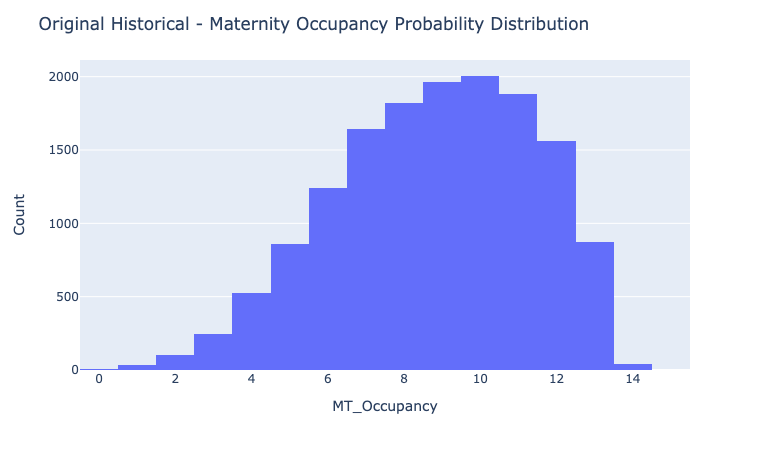

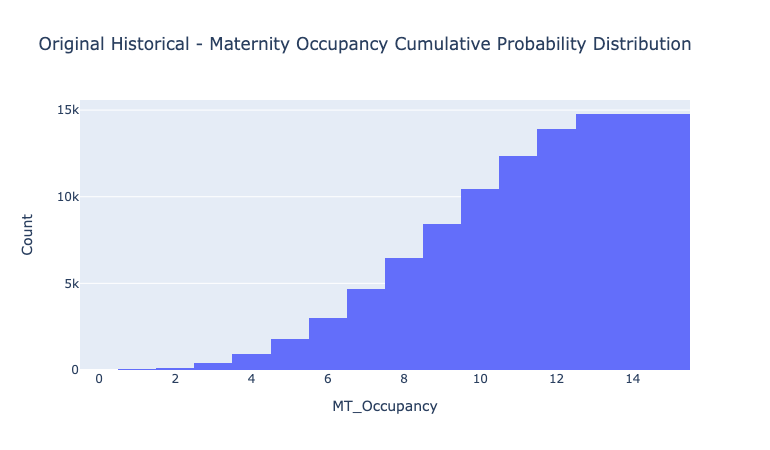

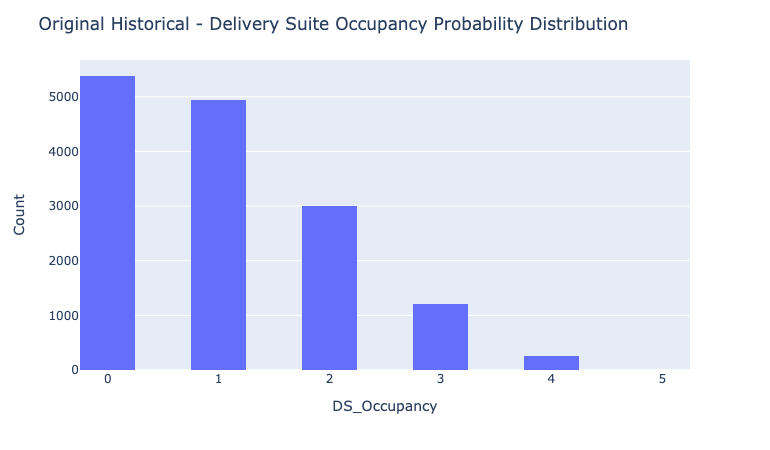

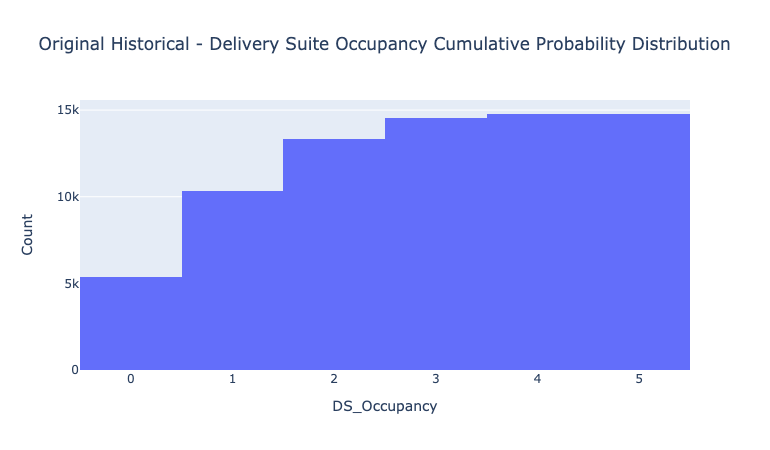

In [18]:
plot_histogram(orig_df, 'MT_Occupancy', 'Histogram', new_dir('plots/'), 'Maternity Occupancy Probability Distribution', 'Original Historical')
plot_histogram(orig_df, 'MT_Occupancy', 'Cummulative Histogram', new_dir('plots/'), 'Maternity Occupancy Cumulative Probability Distribution', 'Original Historical')
plot_histogram(orig_df, 'DS_Occupancy', 'Histogram', new_dir('plots/'), 'Delivery Suite Occupancy Probability Distribution', 'Original Historical')
plot_histogram(orig_df, 'DS_Occupancy', 'Cummulative Histogram', new_dir('plots/'), 'Delivery Suite Occupancy Cumulative Probability Distribution', 'Original Historical')

##### OCCUPANCY PROFILE VISUALISATION - IDEAL FLOW HISTORICAL

In [19]:
ideal_df = add_patient_occupancy(ideal_df)
ideal_df.loc[:,['MT_Occupancy','DS_Occupancy']].describe()

MT_Occupancy  DS_Occupancy
count  14315.000000  14315.000000
mean       9.064198      1.059029
std        2.964369      1.023857
min        0.000000      0.000000
25%        7.000000      0.000000
50%        9.000000      1.000000
75%       11.000000      2.000000
max       20.000000      5.000000

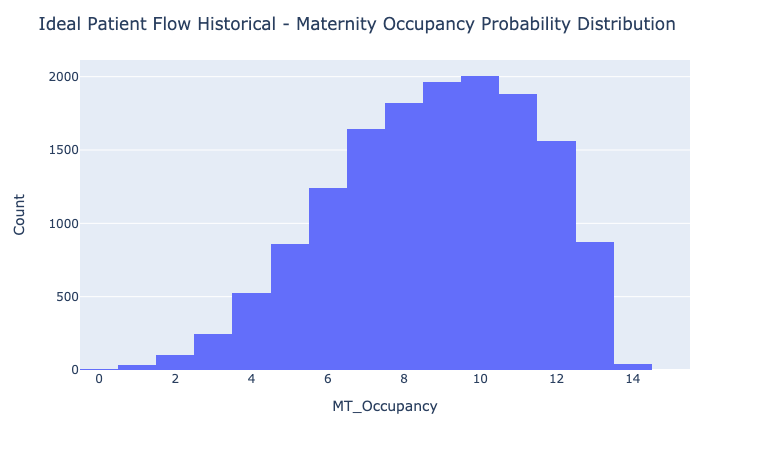

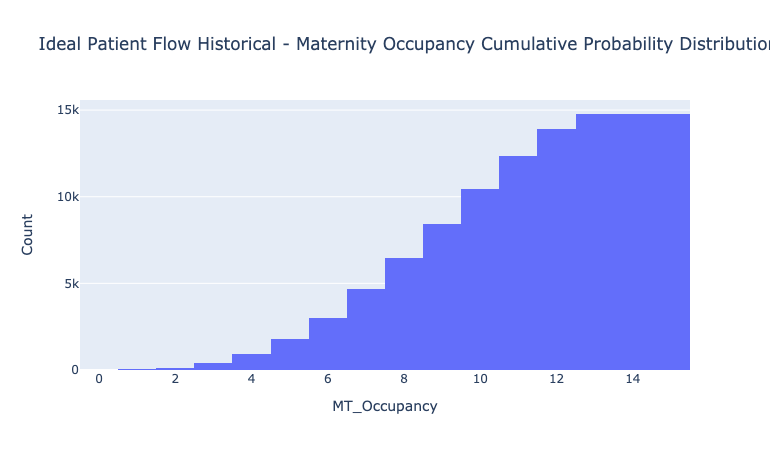

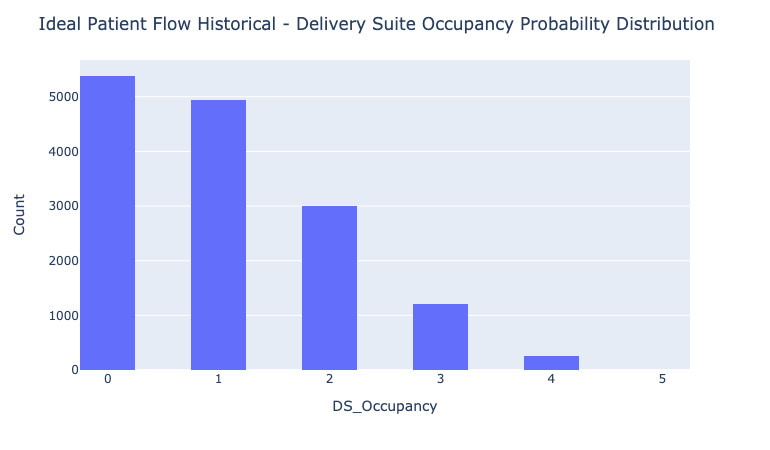

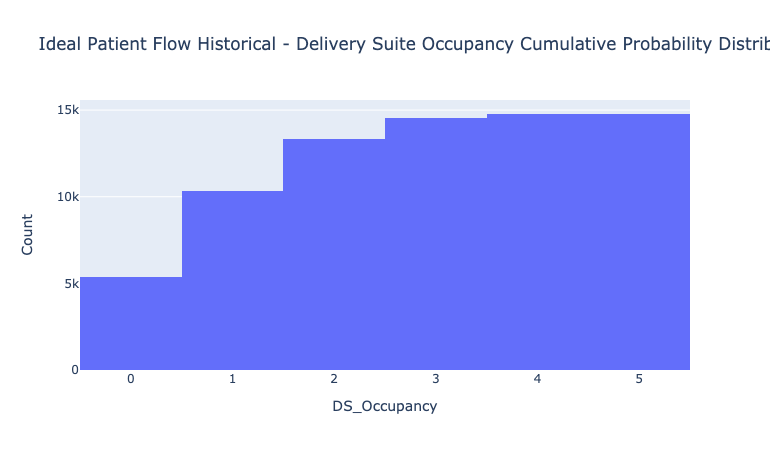

In [20]:
plot_histogram(orig_df, 'MT_Occupancy', 'Histogram', new_dir('plots/'), 'Maternity Occupancy Probability Distribution', 'Ideal Patient Flow Historical')
plot_histogram(orig_df, 'MT_Occupancy', 'Cummulative Histogram', new_dir('plots/'), 'Maternity Occupancy Cumulative Probability Distribution', 'Ideal Patient Flow Historical')
plot_histogram(orig_df, 'DS_Occupancy', 'Histogram', new_dir('plots/'), 'Delivery Suite Occupancy Probability Distribution', 'Ideal Patient Flow Historical')
plot_histogram(orig_df, 'DS_Occupancy', 'Cummulative Histogram', new_dir('plots/'), 'Delivery Suite Occupancy Cumulative Probability Distribution', 'Ideal Patient Flow Historical')

### 2.2 CURRENT OCCUPANCY REQUIREMENTS - SIMULATED MODEL

#### SIMULATION CODE

In [21]:
def next_arrival(df, event_activity, day_type, admission_period, from_year, from_month): 
    xp = pd.Series([0]).append(df.loc[event_activity, day_type, admission_period].iloc[:,0])
    fp = pd.Index([0]).append(df.loc[event_activity, day_type, admission_period].index.remove_unused_categories().categories.right)
    random_no = np.random.rand()
    result = np.interp(random_no, xp, fp) # Straight result based on Mean
    year_mod = year_mod_df.loc[year_mod_df.year == from_year,'modifier'].iloc[0]
    month_mod = month_mod_df.loc[month_mod_df.month == from_month,'modifier'].iloc[0]
    result_modified = result * year_mod * month_mod
    return result_modified
#print(next_arrival(arrivalsum_df, 'High', 'Weekday', 'Planned', 2020, 'January'))

def date_to_hierarcy(date_stamp):
    date_stamp = pd.Timestamp(date_stamp, unit='%d/%m/%Y %H:%M:%S')
    #Extract time period
    hour_of_day = date_stamp.hour
    admission_period = timeconv['Admission_Period'][hour_of_day]
    #Extract type of day (i.e Weekday or Weekend)
    day_of_week = date_stamp.dayofweek
    day_type = dayconv['Day_Type'][day_of_week]
    #Extract Event based activity
    date_only = date_stamp.date()
    try: event = events_df.groupby('Date').Event.first().loc[date_only]
    except: event = 'NONE'
    event_index_no = event_activity['Event'].index(event)
    event_activity_level = event_activity['Event_Activity'][event_index_no]
    #Extract Month
    month = date_stamp.month_name()
    #Extract Year
    year = date_stamp.year
    return {'Admission_Period':admission_period, 'Day_Type':day_type, 'Event_Activity':event_activity_level,'Month':month, 'Year':year}
#print(date_to_hierarcy('01/01/2020 05:00:00'))

def simulate_arrivals(df, n_sims, start, finish):
    results = {'Sim_No':[],'Arrival_Time':[]}
    current_timestamp = pd.Timestamp(start, unit='%d/%m/%Y')
    finish_timestamp = pd.Timestamp(finish, unit='%d/%m/%Y')
    for i in range(0, n_sims):
        while current_timestamp < finish_timestamp:
            hierarcy = date_to_hierarcy(current_timestamp)
            arrival_interval = round(next_arrival(df, hierarcy['Event_Activity'], hierarcy['Day_Type'], hierarcy['Admission_Period'], hierarcy['Year'], hierarcy['Month'])*60*60,0)
            try: current_timestamp += datetime.timedelta(seconds=arrival_interval) 
            except: print(arrival_interval)
            results['Sim_No'].append(i)
            results['Arrival_Time'].append(current_timestamp)
        current_timestamp = pd.Timestamp(start, unit='%d/%m/%Y')
        i += 1
        return results
#print(simulate_arrivals(arrivalsum_df, 2, start, finish))

def simulate_patient_flow(df, group_cat, prev_flow):
    ward_prob = df.loc[(prev_flow)] #group_cat['Event_Activity'], group_cat['Day_Type'], group_cat['Admission_Period'], 
    n = ward_prob.count().iloc[0]
    random_no = np.random.rand()
    for i in range(0, n):
        if random_no <= ward_prob.iloc[i,0]: 
            ward_code = ward_prob.index[i]
            if (prev_flow == 'IN-MT') & (ward_code == 'MT'):
                    print(random_no)
            break 
    return ward_code
#print(simulate_patient_flow(patientflow_df, date_to_hierarcy(start), 'IN-MT'))

def simulate_patient_end(df, start, group_cat, prev_flow, ward_code):
    xp = pd.Series([0]).append(df.loc[prev_flow, ward_code].iloc[:,0]) #group_cat['Event_Activity'], group_cat['Day_Type'], group_cat['Admission_Period'], 
    fp = pd.Index([0]).append(df.loc[prev_flow, ward_code].index.remove_unused_categories().categories.right) #group_cat['Event_Activity'], group_cat['Day_Type'], group_cat['Admission_Period'], 
    #print (xp, fp)
    random_no = np.random.rand()
    dec_result = np.interp(random_no, xp, fp)
    end = start + datetime.timedelta(seconds = int(dec_result*60*60))
    return end
#print(simulate_patient_end(LOS_df, start, date_to_hierarcy(start), 'IN', 'DS'))

def run_simulation(n_sims, arrival_df, LOS_df, patientflow_df, start, finish):
    arrivals_data = simulate_arrivals(arrival_df, n_sims, start, finish)
    no_of_admissions = len(arrivals_data['Sim_No'])
    transfer_info = {'Sim_No':[],'Link':[],'Ward_Code':[],'Start':[],'End':[],'Prev_Flow':[]}
    sim_no = 1
    print(sim_no)
    for i in range(0, no_of_admissions):
        prev_flow, prev_ward = 'IN','IN'
        if sim_no != arrivals_data['Sim_No'][i]:
            sim_no = arrivals_data['Sim_No'][i]
            print(sim_no)
        start = arrivals_data['Arrival_Time'][i]
        link = i
        patient_discharged = False
        group_categories = date_to_hierarcy(start)
        while patient_discharged == False:
            ward = simulate_patient_flow(patientflowsum_df, group_categories, prev_flow)  
            try: end = simulate_patient_end(LOSsum_df, start, group_categories, prev_flow, ward)
            except:
                end = start
            if ward == 'OUT':
                patient_discharged = True

            transfer_info['Sim_No'].append(sim_no)
            transfer_info['Start'].append(start)
            transfer_info['Link'].append(link)
            transfer_info['Prev_Flow'].append(prev_flow)
            transfer_info['Ward_Code'].append(ward)
            transfer_info['End'].append(end)

            #create new starting information
            start = end
            prev_flow = '-'.join((prev_flow, ward))
            prev_ward = ward
            #patient_discharged = True
                                 
    results_df = pd.DataFrame.from_dict(transfer_info)
    return results_df

#%time run_simulation(n_sims, arrival_df, LOS_df, patientflow_df, start, finish)

def all_sims_and_plots(sim_source):
    folder_loc = new_dir('plots/')
    filename = folder_loc + '/Simulation_Data_' + datetime.date.today().isoformat() + '.csv'
    sims = sim_source['sims']
    prev_df = pd.DataFrame()
    no_scenarios = len(sims['title'])
    no_plots = len(sims['plot_info']['name'])
    for i in range(no_scenarios):
        sim_name = sims['title'][i]
        start = pd.Timestamp(sims['start'][i], unit='%d/%m/%Y %H:%M:%S')
        finish =  pd.Timestamp(sims['finish'][i], unit='%d/%m/%Y %H:%M:%S')
        print(sim_name)
        df = run_simulation(sim_source['no_sims'], sim_source['arrival_df'], sim_source['LOS_df'], sim_source['patientflow_df'], start, finish)
        df['Sim_Name'] = sim_name
        df = add_patient_occupancy(df)
        for n in range(no_plots):
            plot_histogram(df, sims['plot_info']['x_axis'][n], sims['plot_info']['plot_type'][n], folder_loc, sims['plot_info']['name'][n], sim_name)
        if prev_df.empty == False:
            df = pd.concat([df, prev_df])
        prev_df = df.copy()
    ##### ADD ALL DESCRIPTIVE COLUMNS TO SIMULATED DATA
    df = add_next_ward(df)
    df = add_hierarical_data(df)
    #df = add_events_data(df)
    df = add_analysis_info(df)
    df.to_csv(filename, index=False)
    return df

#%time simrun_df = all_sims_and_plots(sim_source)

#### CURRENT CAPACITY SIMULATION ACCURACY ANALYSIS

sim2020
1
0


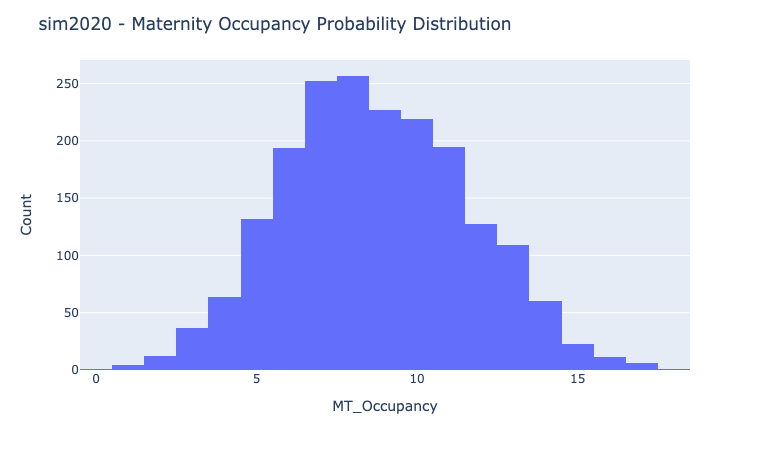

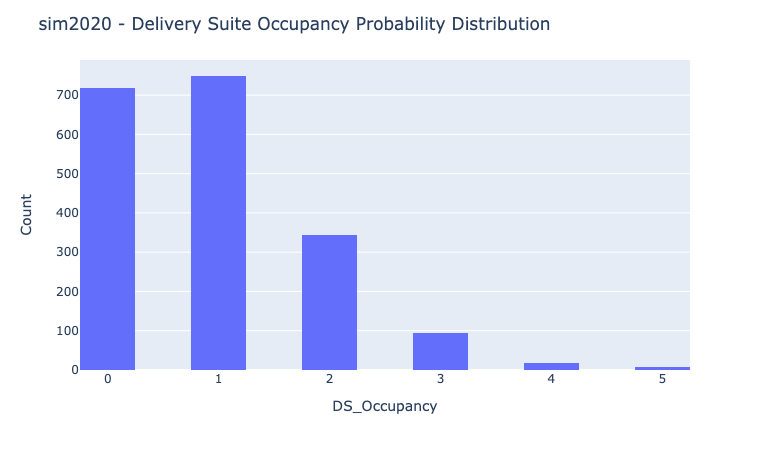

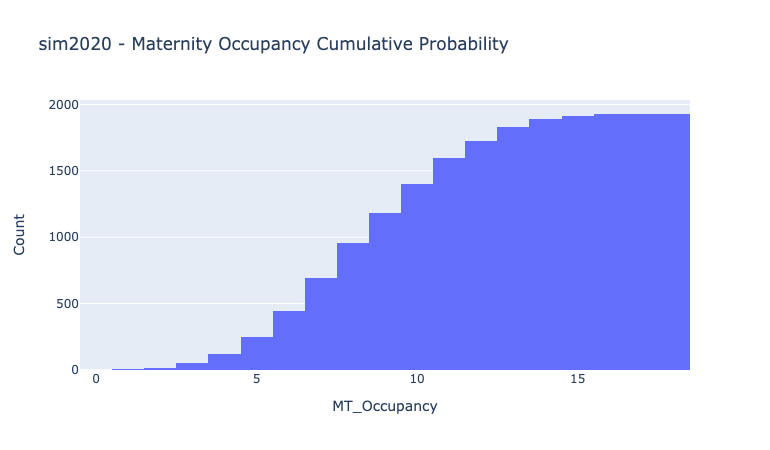

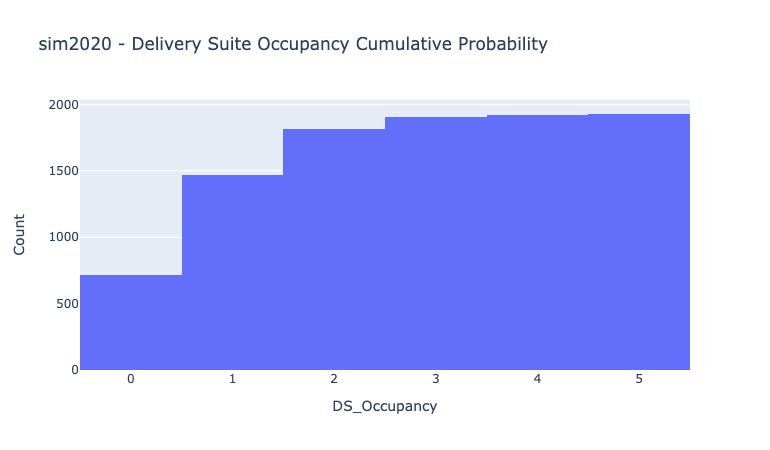

sim2025
1
0


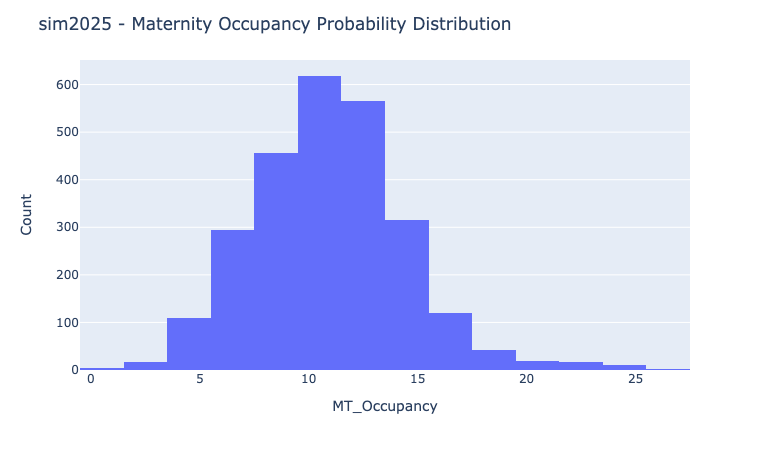

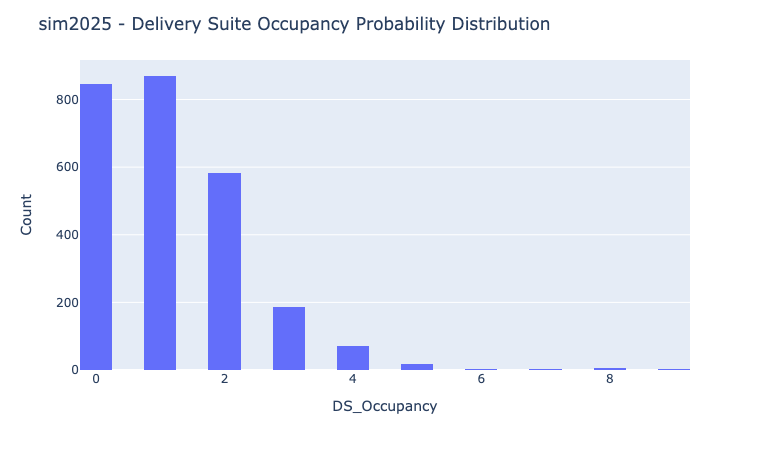

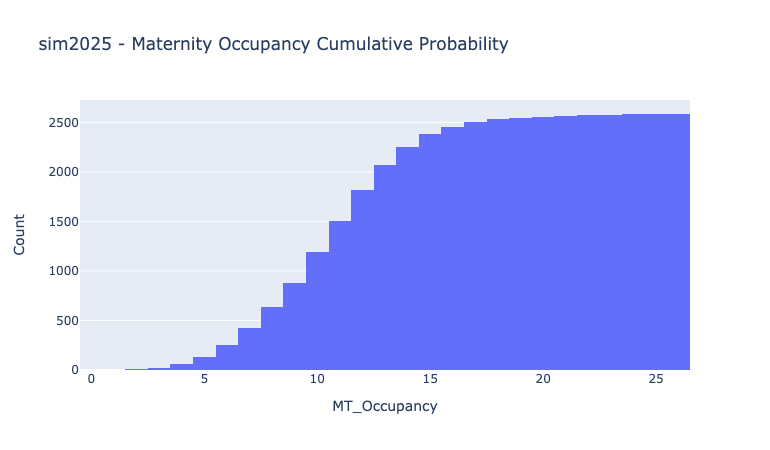

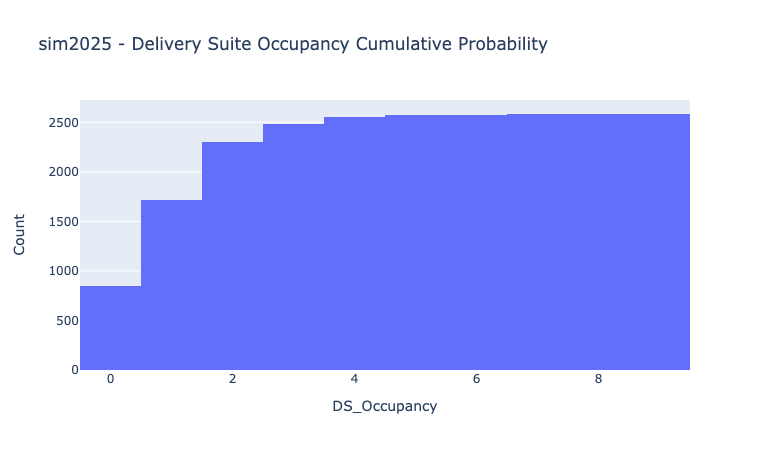

sim2030
1
0


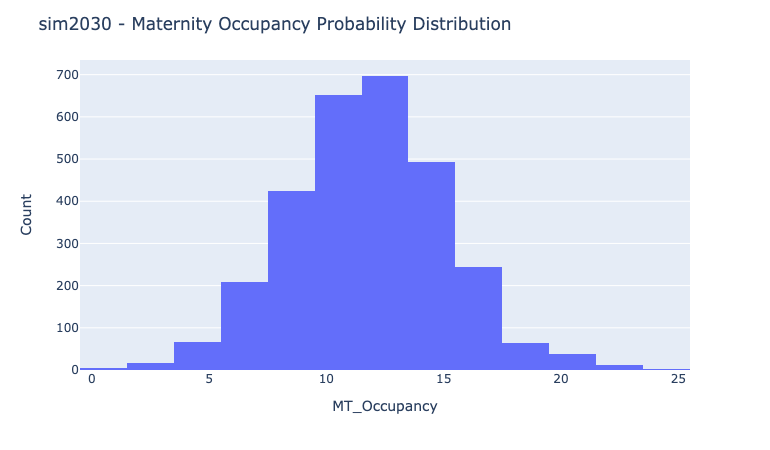

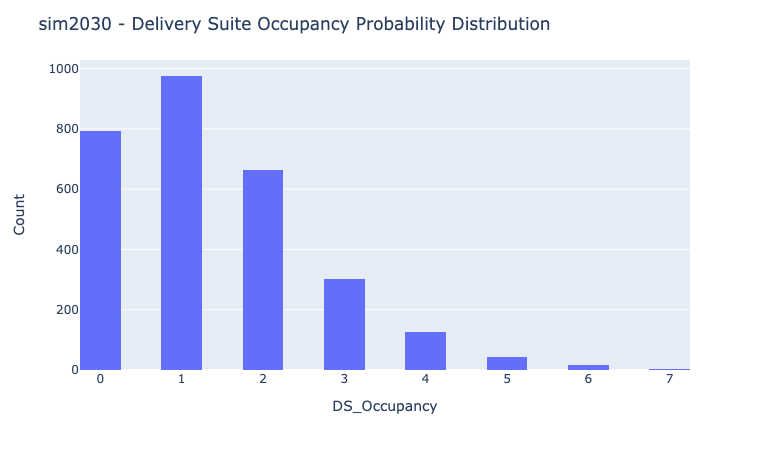

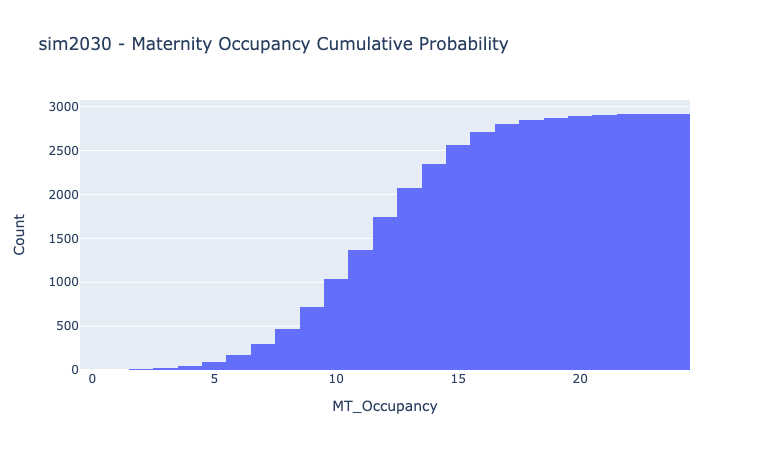

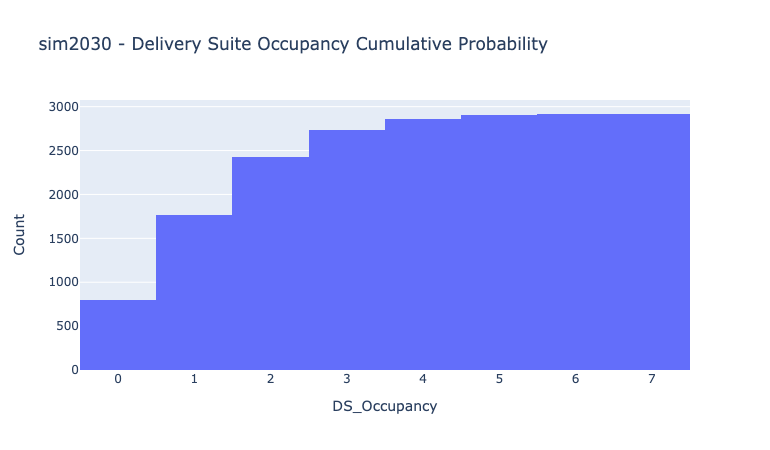

CPU times: user 41.8 s, sys: 81.6 ms, total: 41.9 s
Wall time: 42.8 s


In [22]:
sim_source = {'no_sims':1,
             'arrival_df':arrivalsum_df,
             'LOS_df':LOSsum_df,
             'patientflow_df':patientflowsum_df,
             'sims': {'title':['sim2020','sim2025','sim2030'],
                      'start':['01/01/2020','01/01/2025','01/01/2030'],
                      'finish':['01/01/2021','02/01/2026','02/01/2031'],
                      'plot_info': {'name':['Maternity Occupancy Probability Distribution','Delivery Suite Occupancy Probability Distribution',
                                                 'Maternity Occupancy Cumulative Probability','Delivery Suite Occupancy Cumulative Probability'],
                                      'x_axis':['MT_Occupancy','DS_Occupancy',
                                                'MT_Occupancy','DS_Occupancy'],
                                    'plot_type':['Histogram','Histogram',
                                                 'Cummulative Histogram','Cummulative Histogram'],
                                       }
                         }
             }

%time simrun_df = all_sims_and_plots(sim_source)

## COMBINE ALL DATASETS

In [23]:
df = pd.concat([simrun_df, ideal_df, orig_df])
#df.loc[(df.Sim_Name == 'ideal_hist'),'Full_Flow_Code'].unique()
#df.loc[(df.Sim_Name == 'sim2020')&(df.Full_Flow_Code == 'IN-MT-MT-OUT'),:]
df.loc[df.Sim_Name == 'ideal_hist',:].describe()


Sim_No  MT_Occupancy  DS_Occupancy           Day          Year  \
count  14315.0  14315.000000  14315.000000  14315.000000  14315.000000   
mean       1.0      9.064198      1.059029      2.782885   2016.613273   
std        0.0      2.964369      1.023857      1.967410      2.119510   
min        1.0      0.000000      0.000000      0.000000   2013.000000   
25%        1.0      7.000000      0.000000      1.000000   2015.000000   
50%        1.0      9.000000      1.000000      3.000000   2017.000000   
75%        1.0     11.000000      2.000000      4.000000   2018.000000   
max        1.0     20.000000      5.000000      6.000000   2020.000000   

        Hour_of_Day           LOS  Int_Arrival  
count  14315.000000  14315.000000  6068.000000  
mean      12.368984     42.470994    10.236480  
std        5.163953     50.780610    11.661019  
min        0.000000      0.000000     0.000000  
25%       10.000000      0.000000     2.230000  
50%       11.000000     19.550000     6.600000  
75%       16.000000     86.650000    14.170000  
max       23.000000    835.830000   106.000000

In [24]:
######## REVIEW DATA FROM OBSTETRICS CASES
##### CLEAN TRANSFERS DATA
df = pd.read_csv('Obs_ObstetricCases.csv')
df = df.loc[:,('Link', 'Ward','Admit','SeparationDRGGroupCode')]
obs_df = df
#df = df.loc[df.Ward == 'Maternity',]

df = pd.merge(ideal_df, obs_df, how='left', on='Link')
df.loc[(df.Ward.notnull())].groupby(['Ward_Code','Ward']).count()['Link']



Ward_Code  Ward               
DS         Delivery Suite          271
           Maternity              2049
           St Catherine              7
           St Clares                19
ICU        Intensive Care Unit       2
           Maternity                79
           St Clares                 1
MT         Intensive Care Unit       1
           Maternity              5714
           St Catherine             39
           St Clares                59
           St Helens                 5
OUT        Delivery Suite          271
           Intensive Care Unit       3
           Maternity              5690
           St Catherine             39
           St Clares                61
           St Helens                 5
Name: Link, dtype: int64

In [25]:
obs_df.groupby('SeparationDRGGroupCode').count()['Link']

SeparationDRGGroupCode
O01    2151
O02      98
O04      62
O60    3295
O61      76
O64      86
O65      60
O66     435
Name: Link, dtype: int64

In [26]:
import plotly.express as px
fig = px.bar(annual_plot_df, x='Year', y='Int_Arrival', title='Interarrival Time by Overall Interarrival mean')
fig.show()

NameError: name 'annual_plot_df' is not defined

## ARRIVALS PER YEAR

In [ ]:
# PREPARE DATA FOR ARRIVALS PLOT
df = ideal_df
df = df.loc[df.Year == 2013,'Start'].min()
daysin2013 = df.dayofyear
percentdaysin2013 = (365 - daysin2013) / 365
df = ideal_df
df = df.loc[df.Year == 2020,'End'].max()
daysin2020 = df.dayofyear
percentdaysin2020 = daysin2020 / 365
df = ideal_df
df = df.loc[df.Int_Arrival.notnull(),('Year','Int_Arrival')]
df = df.groupby('Year').count()
df = df.reset_index()
df = df.rename(columns={'Int_Arrival':'No_of_Patients'})
nopatients2013 = df.loc[df.Year == 2013, 'No_of_Patients']
df.loc[df.Year == 2013, 'No_of_Patients'] = int(nopatients2013 / percentdaysin2013)
nopatients2020 = df.loc[df.Year == 2020, 'No_of_Patients']
df.loc[df.Year == 2020, 'No_of_Patients'] = int(nopatients2020 / percentdaysin2020)
#Export Plot to external sheet
df.to_csv("Arrivals_per_Year.csv", index=False)  
plot_arrivals_year = df
#Show plot of datat
fig = px.line(plot_arrivals_year, x='Year', y='No_of_Patients', title='Number of Arrivals')
fig.show()

##  IDEAL FLOW PROBABILITY

In [ ]:
df = ideal_df
total_patients = df.count().iloc[0]
df = df.loc[df.Prev_Flow == 'IN'].groupby(['Full_Flow_Code']).count()['Link']
df = df.reset_index()
df = df.rename(columns={'Link':'No_of_Patients'})
df['Total_Patients'] = total_patients
df['Full_Flow_Code'] = df['Full_Flow_Code'].str[3:-4]
df = df.sort_values('No_of_Patients', ascending = False)
df['Percentage_Patients'] = df.No_of_Patients / df.Total_Patients
df['Cumulative_Probability'] = df.Percentage_Patients.cumsum()
df = df.drop(columns=['No_of_Patients','Total_Patients'])
ideal_patient_flow_prob_plot_df = df
df.to_csv("Ideal_Flow_Probability.csv", index=False)  
#Show plot of data
fig = px.bar(ideal_patient_flow_prob_plot_df, x=df['Full_Flow_Code'], y=df['Percentage_Patients'], title='Patient Flow Probabilities')
fig.add_scatter(x=df['Full_Flow_Code'], y=df['Cumulative_Probability'], name='Cumulative Plot')
fig.show()

In [ ]:
ideal_patient_flow_prob_plot_df

## BRANCHING PROBABILITIES

In [ ]:
####### Data Table for Pie Charts
# Split Full flow code data up
df = ideal_df.copy(deep=True)
df = df.loc[df.Prev_Flow == 'IN'].groupby('Full_Flow_Code').count()['Link'].reset_index()
df1 = df.Full_Flow_Code.str.split(pat="-", expand=True)
df = pd.merge(df, df1, left_index=True, right_index=True)
df = df.rename(columns={'Link':'Values'})
# format each level correctly for plats
lvl1_df = df.iloc[:]
lvl1_df['Prev_Flow'] = df[0]
lvl1_df['Ward_Code'] = df[1]
lvl2_df = df.iloc[:]
lvl2_df['Prev_Flow'] = df[0] + '-' + df[1]
lvl2_df['Ward_Code'] = df[2]
lvl3_df = df.iloc[:]
lvl3_df['Prev_Flow'] = df[0]+'-'+df[1]+'-'+df[2]
lvl3_df['Ward_Code'] = df[3]
lvl4_df = df.iloc[:]
lvl4_df['Prev_Flow'] = df[0]+'-'+df[1]+'-'+df[2]+'-'+df[3]
lvl4_df['Ward_Code'] = df[4]
lvl5_df = df.iloc[:]
lvl5_df['Prev_Flow'] = df[0]+'-'+df[1]+'-'+df[2]+'-'+df[3]+'-'+df[4]
lvl5_df['Ward_Code'] = df[5]
lvl6_df = df.iloc[:]
lvl6_df['Prev_Flow'] = df[0]+'-'+df[1]+'-'+df[2]+'-'+df[3]+'-'+df[4]+'-'+df[5]
lvl6_df['Ward_Code'] = df[6]
#bring information back into single dataframe
df = pd.concat([lvl1_df,lvl2_df,lvl3_df,lvl4_df,lvl5_df,lvl6_df])
df = df.dropna(subset=['Ward_Code'])
df = df.drop(columns=['Full_Flow_Code',0,1,2,3,4,5,6])
pie_df = df.copy(deep = True)
pie_df.head()

In [ ]:
def flow_code_pie_chart(df, prev_flow_code):
    title = prev_flow_code
    filename = 'plots/Patient_Flow/' + title + '.png'
    df = df.loc[df.Prev_Flow == title].groupby('Ward_Code').sum()['Values'].reset_index()
    fig = px.pie(
        data_frame=df,
        values='Values',
        names='Ward_Code',
        color='Ward_Code',
        color_discrete_map = {'MT':'royalblue',
                             'DS':'green',
                             'ICU':'goldenrod',
                             'OUT':'salmon'},
        labels={'Ward_Code':'Next Ward'},
        title=title,
        template='presentation',
        width=800,
        height=600,
        hole=0
    )
    fig.update_traces(textinfo='percent+label')
    #fig.show()
    fig.write_image(filename)
#flow_code_pie_chart(pie_df, 'IN-DS') 
    
def all_flow_code_pie_charts(df):
    temp_df = df.groupby('Prev_Flow').count()['Values'].reset_index()
    for entry in temp_df['Prev_Flow']:
        flow_code_pie_chart(df, entry)
        
%time all_flow_code_pie_charts(pie_df)

## VERIFICATION OF DATA

In [ ]:
df = orig_df
#df = ideal_df

In [ ]:
df.loc[df.Prev_Flow=='IN'].groupby('Ward_Code').count()['Link']
#df.groupby('Full_Flow_Code').count()['Link']
#df.count()['Link']
#df.loc[df.Prev_Flow=='IN'].groupby('Full_Flow_Code').count()['Link']
#df.groupby('Full_Flow_Code').count()['Link']

In [ ]:
#IN-DS-MT-OUT
#df.loc[(df.Full_Flow_Code=='IN-DS-MT-OUT')&(df.Prev_Flow=='IN'),('Link',"Ward_Code",'Start','End','Prev_Flow','Next_Ward')].sort_values(['Link','Start'])
#IN-MT-OUT
df.loc[(df.Full_Flow_Code=='IN-MT-OUT')&(df.Prev_Flow=='IN'),('Link',"Ward_Code",'Start','End','Prev_Flow','Next_Ward')].sort_values(['Link','Start'])

In [ ]:
arrivalsum_df.head(30)

In [ ]:
patientflowsum_df.head(50)

In [ ]:
LOSsum_df.head(50)

## INTERPRETING RESULTS

In [ ]:
ideal_df.groupby('Year').describe()['Int_Arrival']

In [ ]:
####PRINTING
#jupyter nbconvert Patient_Cap_Sim.ipynb --to webpdf --allow-chromium-download